In [ ]:
# Notebook to plot the reaction pathway involving species 85

In [1]:
import os
import pickle
import numpy as np

import rmgpy.species
import rmgpy.chemkin
import rmgpy.data.thermo


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_species_uncertainties(species, uncertainties, labels=None):
    if not type(species) == list:
        species = [species]
    if not type(uncertainties) == list:
        uncertainties = [uncertainties]
    
    if not labels:
        labels = [sp.label for sp in species]
    
    plt.title('Species Uncertainty x10')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Gibbs Free Energy (kJ/mol)')
    T = np.linspace(300, 3000, 1001)
    for j, sp in enumerate(species):
        G = np.zeros(len(T))
        for i in range(0, len(T)):
            G[i] = sp.get_free_energy(T[i]) / 1000.0
        
        plt.plot(T, G, label=labels[j])

        upper_bound = G + 10* uncertainties[j]
        lower_bound = G - 10*uncertainties[j]
        plt.fill_between(T, lower_bound, y2=upper_bound, step="pre", alpha=0.4, color='tab:blue', label=None)
    
    plt.legend()
    plt.show()

In [38]:
# Load the base model and the covariance matrix
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

covariance_file = '/work/westgroup/harris.se/autoscience/autoscience/debug/thermo85/total_covariance_matrix.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_G = pickle.load(handle)


In [6]:
ref_smiles = 'CC(CCOO)O[O]'
for i in range(0, len(species_list)):
    if species_list[i].smiles == ref_smiles:
        print(i, species_list[i])

73 C4H8OOH1-3O2(225)


In [48]:
ref_smiles = 'CC(C[CH]OO)OO'
for i in range(0, len(species_list)):
    if species_list[i].smiles == ref_smiles:
        print(i, species_list[i])

75 C4H71-1,3OOH(238)


In [40]:
print(reaction_list[808])

SC4H9(183) + CC(CCOO)OO(787) <=> C4H8OOH1-3O2(225) + butane(1)


In [42]:
reaction_list[808].get_rate_coefficient(T=550, P=101325)

233981.5749937747

## Find all reactions producing species 85

In [11]:
first_degree_reactions = []
sp85 = species_list[85]
sp73 = species_list[73]
for i, rxn in enumerate(reaction_list):
    rate = rxn.get_rate_coefficient(T=550, P=101325)
    if sp85 in rxn.products and sp73 in rxn.reactants:
        first_degree_reactions.append(rxn)
        print(i, rxn, rate)
    elif sp85 in rxn.reactants and sp73 in rxn.products:
        first_degree_reactions.append(rxn)
        print(i, rxn, rate)


808 SC4H9(183) + CC(CCOO)OO(787) <=> C4H8OOH1-3O2(225) + butane(1) 233981.5749937747
809 PC4H9(182) + CC(CCOO)OO(787) <=> C4H8OOH1-3O2(225) + butane(1) 233981.5749937747
813 HO2(16) + C4H8OOH1-3O2(225) <=> O2(2) + CC(CCOO)OO(787) 714534.8074542894
814 H2O2(17) + C4H8OOH1-3O2(225) <=> HO2(16) + CC(CCOO)OO(787) 30.35224263152591
816 OH(15) + CC(CCOO)OO(787) <=> H2O(8) + C4H8OOH1-3O2(225) 1640728.7807330228
818 HCO(19) + CC(CCOO)OO(787) <=> CH2O(9) + C4H8OOH1-3O2(225) 2.2401653154432497e-14
820 C4H71-3(190) + CC(CCOO)OO(787) <=> C4H8-2(189) + C4H8OOH1-3O2(225) 0.3887388207843497
821 C4H8-1(188) + C4H8OOH1-3O2(225) <=> C4H71-3(190) + CC(CCOO)OO(787) 6.380213929389688
826 CH2CHO(21) + CC(CCOO)OO(787) <=> CH3CHO(35) + C4H8OOH1-3O2(225) 225.25302405078327
827 CH3CO(20) + CC(CCOO)OO(787) <=> CH3CHO(35) + C4H8OOH1-3O2(225) 2.2401653154432497e-14
829 C2H3(22) + CC(CCOO)OO(787) <=> C2H4(11) + C4H8OOH1-3O2(225) 4152328.065752566
830 C3H5-A(94) + CC(CCOO)OO(787) <=> C3H6(12) + C4H8OOH1-3O2(225) 0.7

In [31]:
# rank the reactions that produce the most species 85
reactions_73to85 = []
rates_73to85 = []
sp85 = species_list[85]
sp73 = species_list[73]
for i, rxn in enumerate(reaction_list):
    if sp85 in rxn.products and sp73 in rxn.reactants:  # these produce species 85, so keep rate forward
        rate = rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)
    elif sp85 in rxn.reactants and sp73 in rxn.products:  # reverse these rates
        reverse_rxn = rxn.generate_reverse_rate_coefficient()
        rate = reverse_rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)


order_rxn = np.arange(0, len(reactions_73to85))
rates = np.array(rates_73to85)
fastest_rxns = [x for _, x in sorted(zip(rates, order_rxn))][::-1]


# rates_73to85 = np.array(rates_73to85)
# # [print(type(rate)) for rate in rates_73to85]
# reaction_order = [x for _, x in sorted(zip(rates_73to85, reactions_73to85))][::-1]

In [35]:
print('Fastest reactions producing species 85')
for i in range(0, 10):
    index = fastest_rxns[i]
    rmg_index = reaction_list.index(reactions_73to85[index])
    print(rmg_index, '\t', rates_73to85[index], reactions_73to85[index])

Fastest reactions producing species 85
873 	 51200000.00000001 HCO(19) + C4H8OOH1-3O2(225) <=> CO(6) + CC(CCOO)OO(787)
835 	 16169555.527577324 H(14) + C4H8OOH1-3O2(225) <=> CC(CCOO)OO(787)
877 	 6436633.7161551835 C2H5(33) + C4H8OOH1-3O2(225) <=> C2H4(11) + CC(CCOO)OO(787)
843 	 6436633.7161551835 CH3O(31) + C4H8OOH1-3O2(225) <=> CH2O(9) + CC(CCOO)OO(787)
1279 	 4291089.144103455 C2H3(22) + C4H8OOH1-3O2(225) <=> C2H2(25) + CC(CCOO)OO(787)
865 	 3854939.117724508 CH3CO(20) + C4H8OOH1-3O2(225) <=> CH2CO(24) + CC(CCOO)OO(787)
813 	 714534.8074542894 HO2(16) + C4H8OOH1-3O2(225) <=> O2(2) + CC(CCOO)OO(787)
1241 	 468900.0136399722 C3H5O(129) + C4H8OOH1-3O2(225) <=> C2H3CHO(74) + CC(CCOO)OO(787)
979 	 468900.0136399722 C2H5O(49) + C4H8OOH1-3O2(225) <=> CH3CHO(35) + CC(CCOO)OO(787)
932 	 468900.0136399722 CC(CC[O])OO(777) + C4H8OOH1-3O2(225) <=> NC4KET13(252) + CC(CCOO)OO(787)


## Copy for the model with just t85 changd

In [37]:
# Load the base model and the covariance matrix
basedir85 = '/work/westgroup/harris.se/autoscience/autoscience/debug/thermo85'

base_chemkin = os.path.join(basedir85, 'thermo_only_85.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)


# rank the reactions that produce the most species 85
reactions_73to85 = []
rates_73to85 = []
sp85 = species_list[85]
sp73 = species_list[73]
for i, rxn in enumerate(reaction_list):
    if sp85 in rxn.products and sp73 in rxn.reactants:  # these produce species 85, so keep rate forward
        rate = rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)
    elif sp85 in rxn.reactants and sp73 in rxn.products:  # reverse these rates
        reverse_rxn = rxn.generate_reverse_rate_coefficient()
        rate = reverse_rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)


order_rxn = np.arange(0, len(reactions_73to85))
rates = np.array(rates_73to85)
fastest_rxns = [x for _, x in sorted(zip(rates, order_rxn))][::-1]


print('Fastest reactions producing species 85')
for i in range(0, 10):
    index = fastest_rxns[i]
    rmg_index = reaction_list.index(reactions_73to85[index])
    print(rmg_index, '\t', rates_73to85[index], reactions_73to85[index])

Fastest reactions producing species 85
873 	 51200000.00000001 HCO(19) + C4H8OOH1-3O2(225) <=> CO(6) + CC(CCOO)OO(787)
835 	 16169555.527577324 H(14) + C4H8OOH1-3O2(225) <=> CC(CCOO)OO(787)
877 	 6436633.7161551835 C2H5(33) + C4H8OOH1-3O2(225) <=> C2H4(11) + CC(CCOO)OO(787)
843 	 6436633.7161551835 CH3O(31) + C4H8OOH1-3O2(225) <=> CH2O(9) + CC(CCOO)OO(787)
1279 	 4291089.144103455 C2H3(22) + C4H8OOH1-3O2(225) <=> C2H2(25) + CC(CCOO)OO(787)
865 	 3854939.117724508 CH3CO(20) + C4H8OOH1-3O2(225) <=> CH2CO(24) + CC(CCOO)OO(787)
808 	 1490929.1947903202 SC4H9(183) + CC(CCOO)OO(787) <=> C4H8OOH1-3O2(225) + butane(1)
813 	 714534.8074542894 HO2(16) + C4H8OOH1-3O2(225) <=> O2(2) + CC(CCOO)OO(787)
1241 	 468900.0136399722 C3H5O(129) + C4H8OOH1-3O2(225) <=> C2H3CHO(74) + CC(CCOO)OO(787)
979 	 468900.0136399722 C2H5O(49) + C4H8OOH1-3O2(225) <=> CH3CHO(35) + CC(CCOO)OO(787)


## Species 74  C4H8OOH2-4O2(229)

In [43]:
# try the other species
ref_smiles = 'CC(CCO[O])OO'
for i in range(0, len(species_list)):
    if species_list[i].smiles == ref_smiles:
        print(i, species_list[i])

74 C4H8OOH2-4O2(229)


In [45]:
# Load the base model and the covariance matrix
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

# rank the reactions that produce the most species 85
reactions_73to85 = []
rates_73to85 = []
sp85 = species_list[85]
sp73 = species_list[74]
for i, rxn in enumerate(reaction_list):
    if sp85 in rxn.products and sp73 in rxn.reactants:  # these produce species 85, so keep rate forward
        rate = rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)
    elif sp85 in rxn.reactants and sp73 in rxn.products:  # reverse these rates
        reverse_rxn = rxn.generate_reverse_rate_coefficient()
        rate = reverse_rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)


order_rxn = np.arange(0, len(reactions_73to85))
rates = np.array(rates_73to85)
fastest_rxns = [x for _, x in sorted(zip(rates, order_rxn))][::-1]


print('Fastest reactions producing species 85')
for i in range(0, 10):
    index = fastest_rxns[i]
    rmg_index = reaction_list.index(reactions_73to85[index])
    print(rmg_index, '\t', rates_73to85[index], reactions_73to85[index])

Fastest reactions producing species 85
874 	 51200000.00000001 HCO(19) + C4H8OOH2-4O2(229) <=> CO(6) + CC(CCOO)OO(787)
836 	 16169555.527577324 H(14) + C4H8OOH2-4O2(229) <=> CC(CCOO)OO(787)
878 	 6436633.7161551835 C2H5(33) + C4H8OOH2-4O2(229) <=> C2H4(11) + CC(CCOO)OO(787)
844 	 6436633.7161551835 CH3O(31) + C4H8OOH2-4O2(229) <=> CH2O(9) + CC(CCOO)OO(787)
1280 	 4291089.144103455 C2H3(22) + C4H8OOH2-4O2(229) <=> C2H2(25) + CC(CCOO)OO(787)
866 	 3854939.117724508 CH3CO(20) + C4H8OOH2-4O2(229) <=> CH2CO(24) + CC(CCOO)OO(787)
812 	 714534.8074542894 HO2(16) + C4H8OOH2-4O2(229) <=> O2(2) + CC(CCOO)OO(787)
1242 	 468900.0136399722 C3H5O(129) + C4H8OOH2-4O2(229) <=> C2H3CHO(74) + CC(CCOO)OO(787)
980 	 468900.0136399722 C2H5O(49) + C4H8OOH2-4O2(229) <=> CH3CHO(35) + CC(CCOO)OO(787)
933 	 468900.0136399722 CC(CC[O])OO(777) + C4H8OOH2-4O2(229) <=> NC4KET13(252) + CC(CCOO)OO(787)


In [46]:
# Load the base model and the covariance matrix
basedir85 = '/work/westgroup/harris.se/autoscience/autoscience/debug/thermo85'

base_chemkin = os.path.join(basedir85, 'thermo_only_85.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

# rank the reactions that produce the most species 85
reactions_73to85 = []
rates_73to85 = []
sp85 = species_list[85]
sp73 = species_list[74]
for i, rxn in enumerate(reaction_list):
    if sp85 in rxn.products and sp73 in rxn.reactants:  # these produce species 85, so keep rate forward
        rate = rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)
    elif sp85 in rxn.reactants and sp73 in rxn.products:  # reverse these rates
        reverse_rxn = rxn.generate_reverse_rate_coefficient()
        rate = reverse_rxn.get_rate_coefficient(T=550, P=101325)
        reactions_73to85.append(rxn)
        rates_73to85.append(rate)
#         print(i, rxn, rate)


order_rxn = np.arange(0, len(reactions_73to85))
rates = np.array(rates_73to85)
fastest_rxns = [x for _, x in sorted(zip(rates, order_rxn))][::-1]


print('Fastest reactions producing species 85')
for i in range(0, 10):
    index = fastest_rxns[i]
    rmg_index = reaction_list.index(reactions_73to85[index])
    print(rmg_index, '\t', rates_73to85[index], reactions_73to85[index])

Fastest reactions producing species 85
874 	 51200000.00000001 HCO(19) + C4H8OOH2-4O2(229) <=> CO(6) + CC(CCOO)OO(787)
836 	 16169555.527577324 H(14) + C4H8OOH2-4O2(229) <=> CC(CCOO)OO(787)
878 	 6436633.7161551835 C2H5(33) + C4H8OOH2-4O2(229) <=> C2H4(11) + CC(CCOO)OO(787)
844 	 6436633.7161551835 CH3O(31) + C4H8OOH2-4O2(229) <=> CH2O(9) + CC(CCOO)OO(787)
1280 	 4291089.144103455 C2H3(22) + C4H8OOH2-4O2(229) <=> C2H2(25) + CC(CCOO)OO(787)
866 	 3854939.117724508 CH3CO(20) + C4H8OOH2-4O2(229) <=> CH2CO(24) + CC(CCOO)OO(787)
804 	 1438417.9467025553 SC4H9(183) + CC(CCOO)OO(787) <=> C4H8OOH2-4O2(229) + butane(1)
812 	 714534.8074542894 HO2(16) + C4H8OOH2-4O2(229) <=> O2(2) + CC(CCOO)OO(787)
1242 	 468900.0136399722 C3H5O(129) + C4H8OOH2-4O2(229) <=> C2H3CHO(74) + CC(CCOO)OO(787)
980 	 468900.0136399722 C2H5O(49) + C4H8OOH2-4O2(229) <=> CH3CHO(35) + CC(CCOO)OO(787)


In [47]:
ref_smiles = 'C[C](CCOO)OO'
for i in range(0, len(species_list)):
    if species_list[i].smiles == ref_smiles:
        print(i, species_list[i])

76 C4H72-2,4OOH(244)


## Plot first pathway

In [56]:
# plot the first pathway
# Load the base model
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

basedir85 = '/work/westgroup/harris.se/autoscience/autoscience/debug/thermo85'
base_chemkin = os.path.join(basedir85, 'thermo_only_85.inp')
species_list85, reaction_list85 = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)


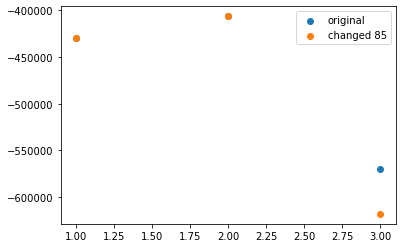

In [58]:
species_indices = [74, 76, 85]

free_energies = np.zeros(len(species_indices))
free_energies85 = np.zeros(len(species_indices))


for i, rmg_index in enumerate(species_indices):
    free_energies[i] = species_list[rmg_index].get_free_energy(550)
    free_energies85[i] = species_list85[rmg_index].get_free_energy(550)
    
    
plt.scatter([1, 2, 3], free_energies)
plt.scatter([1, 2, 3], free_energies85)
plt.legend(['original', 'changed 85'])

In [8]:
print(len(first_degree_reactions))

49


In [ ]:
species_list[85]

In [ ]:
# load the new thermo estimate
DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"

thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
ark_thermo_database.load_libraries(thermo_lib)
print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} entries')

for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
    entry = ark_thermo_database.libraries['harris_butane'].entries[key]
    if entry.item.smiles == species_list[85].smiles:
        break
        
dft_sp = rmgpy.species.Species(smiles=species_list[85].smiles)
dft_sp.thermo = entry.data
print(dft_sp)

In [ ]:
# uncertainty estimate by hand:
# {'GAV': {'group': [(<Entry index=2335 label="O2s-OsCs">, 2),
#    (<Entry index=2317 label="O2s-OsH">, 2),
#    (<Entry index=1908 label="Cs-CsCsOsH">, 1),
#    (<Entry index=953 label="Cs-CsCsHH">, 1),
#    (<Entry index=1952 label="Cs-CsOsHH">, 1),
#    (<Entry index=921 label="Cs-CsHHH">, 1)]}}

group_uncertainty = 0.1
uncertainty_85 = 1.5 + group_uncertainty * (2 + 1 + 1 + 1 + 1)
print(uncertainty_85)

In [ ]:
# plot the original uncertainty
print(species_list[85])
uncertainty_GAV = Sigma_G[85, 85] * 4.184  # convert kcal/mol to kJ/mol
plot_species_uncertainties([species_list[85], dft_sp], [uncertainty_GAV, 1.5], labels=['RMG GAV', 'DFT'])

In [ ]:
Sigma_G[85, 85]

In [ ]:
Sigma_G[0,0]

In [ ]:
species_list[0].label

In [ ]:
dir(species_list[0])

In [ ]:
plot_reaction_uncertainty

In [ ]:
def plot_thermos(thermos, labels=None):
    %matplotlib inline
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for thermo in thermos:
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H)
        ax[1].plot(T, S)
        ax[2].plot(T, Cp)
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [ ]:
# Load the base model
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)
print(f'{len(species_list)} species, {len(reaction_list)} reactions')


In [ ]:
# Load the new thermo library
DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"
thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
ark_thermo_database.load_libraries(thermo_lib)
print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} entries')

In [ ]:
# stitch each of the library thermos into the mechanism
plot_index = 85

species = species_list[plot_index]

for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
    entry = ark_thermo_database.libraries['harris_butane'].entries[key]

    if entry.item.smiles == species_list[plot_index].smiles:
        plot_thermos([species_list[plot_index], entry.data], ['RMG GAV', 'DFT'])
        plot_thermo_diff(species_list[plot_index], entry.data)
        break

In [ ]:
# make a copy to perturb
